In [638]:
%matplotlib inline

import csv
import numpy as np
import pandas as pd
import codecs
import time
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import cross_validation
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

Merging all existing data together

In [639]:
def open_data_file(file_path):
    f1 = csv.reader(open(file_path))
    header = next(f1)
    data = []
    for row in f1:
        data.append(row)
        
    datafr = pd.DataFrame(data, dtype="float")
    datafr.columns = ["id","A","B","C","D"]
    return datafr

In [640]:
# Convert probablities into answers
def get_answers(pandas_df_prob):

    df = list(map(lambda x: np.argmax(pandas_df_prob.iloc[x,1:]), range(pandas_df_prob.shape[0])))
    return np.array(df)

def fill_nans (x):
    #print (pd.isnull(x))
    val = 0
    if pd.isnull(x):
        val = 0
    else:
        val =x
    return x


In [641]:
## Loading data

all_data = pd.read_csv ("../data/joined_set.tsv", sep = '\t' )

probs_gl_6B_300d = open_data_file("../predictions/prob_prediction_glove_dict_glove.6B.300d.csv")
probs_gl_twit_27B_200D = open_data_file("../predictions/prob_prediction_glove_dict_glove.twitter.27B.200d.csv")
probs_ck_12 = open_data_file("../predictions/prob_prediction_ck12.csv")


probs_ck_12 = pd.DataFrame(scale (probs_ck_12,axis=0))
print ()
X_full = pd.concat ([probs_gl_6B_300d, probs_gl_twit_27B_200D.iloc[:,1:],probs_ck_12.iloc[:,1:]], axis=1)



In [642]:
## removin nulls
print ("nulls by column")
print (X_full.isnull().sum())
    
X_full = X_full.fillna (0) 
print (X_full.iloc[17:20,:])

nulls by column
id       0
A      386
B      391
C      372
D      400
A     1132
B     1143
C     1115
D     1131
1        0
2        0
3        0
4        0
dtype: int64
        id         A         B         C         D         A         B  \
17  100018  0.474552  0.000000  0.450218 -0.124574  0.621523  0.000000   
18  100019  0.520808  0.516180  0.716305  0.670864  0.670022  0.680622   
19  100020  0.377641  0.251784  0.258041  0.304747  0.528533  0.433635   

           C         D         1         2         3         4  
17  0.639909  0.000000 -0.370709 -0.374160 -0.385057 -0.389015  
18  0.786480  0.790769 -0.377903 -0.323398 -0.252845 -0.263130  
19  0.507621  0.564263 -0.377331 -0.374160 -0.356060 -0.353271  


In [632]:
## splitting data into test & train:

ind_train = all_data["correctAnswer"] != "-1"


y = all_data[ind_train].iloc[:,6]
X = X_full[ind_train].iloc[:,1:]
X_no_label = X_full[~ind_train].iloc[:,1:]
quest_ids = all_data[~ind_train].iloc[:,0]

print ("Total train: ",len(X))
print ("Total test: ", len(X_no_label),"\n")

X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.3, random_state=42)
print ("test: ",len(X_train))
print ("test: ",len(X_test))

print ("Variables: ",X.columns.values)

Total train:  2500
Total test:  8132 

test:  1750
test:  750
Variables:  ['A' 'B' 'C' 'D' 'A' 'B' 'C' 'D' 1 2 3 4]


Assessing Models Scores:

In [607]:
def evaluate_score (y_model, y_real):
    model_score = sum(y_model==y_real)/len(y_real)
    return model_score

def class_to_binary (y_class,class_label):
    y_class [y_class==class_label] = 1
    y_class [y_class!=1] = 0
    y_class = y_class.astype(float)
    return y_class

def binary_to_label (y_bin_class,class_label):
    y_bin_class = y_bin_class.astype(str)
    y_bin_class [y_bin_class=="A"] = class_label
    y_bin_class [y_bin_class!=class_label] = ""
    return y_bin_class

In [608]:
v1_answ = get_answers (probs_gl_6B_300d)
print ("probs_gl_6B_300d  score:", evaluate_score(v1_answ[:2500],y))


v1_answ = get_answers (probs_gl_twit_27B_200D)
print ("probs_gl_twit_27B_200D  score:",evaluate_score(v1_answ[:2500],y))


probs_gl_6B_300d  score: 0.3044
probs_gl_twit_27B_200D  score: 0.2736


In [670]:
C_arange = np.arange (1,2,5)

gr1_points =[]
gr2_points =[]
gr3_points =[]
#print (X_train)
for C_par in C_arange:
    #clf = LogisticRegression (penalty='l1', C=C_par, random_state= 84)
    clf = AdaBoostClassifier (n_estimators=91, learning_rate=0.05, random_state= 84)
    
    scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=8)
    print (scores)
    gr1_points.append(scores.mean())
    gr2_points.append(scores.min())
    clf.fit (X_train,y_train)
    y_pred = clf.predict(X_test)
    gr3_points.append(evaluate_score(y_pred,y_test))
    print (C_par," ", evaluate_score(y_pred,y_test))

[ 0.34545455  0.32727273  0.27727273  0.32876712  0.28310502  0.25688073
  0.28899083  0.29166667]
1   0.324


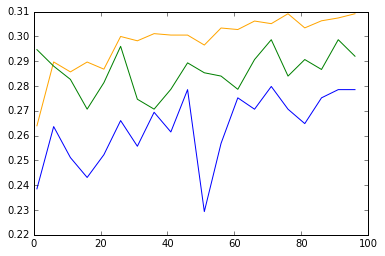

In [661]:
plt.plot (C_arange,gr1_points,color="orange")
plt.plot (C_arange,gr2_points,color="blue")
plt.plot (C_arange,gr3_points,color="green")
plt.show ()

Building Logistic Regression

In [673]:
clf = LogisticRegression (penalty='l1', C=0.35, random_state= 84)
clf = AdaBoostClassifier (n_estimators=91, learning_rate=0.05, random_state= 84)
clf.fit (X_train,y_train)
y_pred = clf.predict(X_no_label)

predicted_data = pd.DataFrame({'id': quest_ids,'correctAnswer': y_pred})[['id', 'correctAnswer']]

predicted_data.to_csv("../predictions/assemble_model_ada_boost.csv", index = False)
print (predicted_data)

           id correctAnswer
2500   102501             C
2501   102502             C
2502   102503             B
2503   102504             C
2504   102505             D
2505   102506             C
2506   102507             B
2507   102508             B
2508   102509             B
2509   102510             C
2510   102511             A
2511   102512             C
2512   102513             B
2513   102514             C
2514   102515             D
2515   102516             D
2516   102517             A
2517   102518             D
2518   102519             B
2519   102520             B
2520   102521             D
2521   102522             B
2522   102523             A
2523   102524             D
2524   102525             C
2525   102526             D
2526   102527             B
2527   102528             D
2528   102529             B
2529   102530             B
...       ...           ...
10602  110603             D
10603  110604             C
10604  110605             C
10605  110606       